# Multiclass Logistic Regression
- Importo il dataset
- Elimino attributi categorici e non necessari
- Assemblo le features
- Normalizzo i dati
- Univariate Feature Reduction
- Sampling (solo per il tuning dei parametri)
- Split Training/Test set
- Fitting & Prediction del/i modello/i
- Evaluation

In [116]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StringIndexer, IndexToString
from pyspark.ml.feature import PCA, UnivariateFeatureSelector
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import *

In [117]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Multiclass LogisticRegression") \
    .getOrCreate()

### Importo il dataset

In [118]:
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
data = data.withColumnRenamed('winPlaceClass', 'label')

In [119]:
data.printSchema()

root
 |-- groupId: string (nullable = true)
 |-- matchId: string (nullable = true)
 |-- matchDuration: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- isFirstPerson: boolean (nullable = true)
 |-- matchtype: integer (nullable = true)
 |-- maxPlace: integer (nullable = true)
 |-- numGroups: integer (nullable = true)
 |-- hasDisconnected: integer (nullable = true)
 |-- assist_SUM: integer (nullable = true)
 |-- assist_MAX: integer (nullable = true)
 |-- assist_AVG: integer (nullable = true)
 |-- heals_SUM: integer (nullable = true)
 |-- heals_MAX: integer (nullable = true)
 |-- heals_AVG: integer (nullable = true)
 |-- kills_SUM: integer (nullable = true)
 |-- kills_MAX: integer (nullable = true)
 |-- kills_AVG: integer (nullable = true)
 |-- headshotKills_SUM: integer (nullable = true)
 |-- headshotKills_MAX: integer (nullable = true)
 |-- headshotKills_AVG: integer (nullable = true)
 |-- killStreaks_MAX: integer (nullable = true)
 |-- roadKills_SUM: integer (nullab

In [120]:
# Elimino gli attributi non necessari
inputCols =  data.columns
toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'label','isFirstPerson']
inputCols = list(set(inputCols) - set(toRemove))

#### Assemblo le features

In [121]:
assemble = VectorAssembler(inputCols = inputCols, outputCol = 'features')
data = assemble.transform(data)

In [122]:
data.select("features","label").show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(50,[1,2,3,4,6,7,...|    4|
|(50,[1,2,4,6,9,10...|    4|
|(50,[1,2,6,7,9,11...|    4|
|(50,[1,2,4,5,6,9,...|    2|
|(50,[2,4,6,7,9,10...|    4|
+--------------------+-----+
only showing top 5 rows



#### Normalizzo i dati

In [123]:
scaler = MinMaxScaler(inputCol='features',outputCol="scaled")
data = scaler.fit(data).transform(data)

In [124]:
data.select("scaled","label").show(5)

+--------------------+-----+
|              scaled|label|
+--------------------+-----+
|(50,[1,2,3,4,6,7,...|    4|
|(50,[1,2,4,6,9,10...|    4|
|(50,[1,2,6,7,9,11...|    4|
|(50,[1,2,4,5,6,9,...|    2|
|(50,[2,4,6,7,9,10...|    4|
+--------------------+-----+
only showing top 5 rows



#### Univariate Feature Selector

In [125]:
selector = UnivariateFeatureSelector(featuresCol='scaled',labelCol='label',outputCol='selected')
selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(30)
data = selector.fit(data).transform(data)

In [126]:
data.select("selected","label").show(5)

+--------------------+-----+
|            selected|label|
+--------------------+-----+
|(30,[1,2,3,4,6,7,...|    4|
|(30,[1,2,4,6,9,10...|    4|
|(30,[1,2,6,7,9,11...|    4|
|(30,[1,2,4,5,6,9,...|    2|
|(30,[2,4,6,7,9,10...|    4|
+--------------------+-----+
only showing top 5 rows



#### Sampling

In [127]:
data = data.sample(withReplacement=False, fraction=1.0, seed=42)

In [128]:
data = data.select("selected","label")
data = data.withColumnRenamed("selected", "features")
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(30,[1,2,3,4,6,7,...|    4|
|(30,[1,2,4,6,9,10...|    4|
|(30,[1,2,6,7,9,11...|    4|
|(30,[1,2,4,5,6,9,...|    2|
|(30,[2,4,6,7,9,10...|    4|
+--------------------+-----+
only showing top 5 rows



### Split Training/Test Set

In [129]:
(training,test) = data.randomSplit([0.7,0.3])

print(F'training: {training.count()}')
print(F'test: {test.count()}')

training: 1409618
test: 604472


In [130]:
# ripartizione delle classi - training set
training.select("label").groupby("label").count().sort("label").show(10)

+-----+------+
|label| count|
+-----+------+
|    1| 33046|
|    2|329656|
|    3|330066|
|    4|347536|
|    5|336449|
|    6| 32865|
+-----+------+



In [131]:
# ripartizione delle classi - test set
test.select("label").groupby("label").count().sort("label").show(10)

+-----+------+
|label| count|
+-----+------+
|    1| 14069|
|    2|141577|
|    3|141615|
|    4|148924|
|    5|143967|
|    6| 14320|
+-----+------+



### Logistic Regression

In [132]:
training.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(30,[0,1,2,3,4,5,...|    2|
|(30,[0,1,2,3,4,5,...|    4|
|(30,[0,1,2,3,4,5,...|    2|
|(30,[0,1,2,3,4,5,...|    3|
|(30,[0,1,2,3,4,5,...|    3|
+--------------------+-----+
only showing top 5 rows



In [133]:
lr = LogisticRegression(maxIter=10, regParam=0.01)

In [134]:
model = lr.fit(training)

In [135]:
predictions = model.transform(test)
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(30,[0,1,2,3,4,5,...|    3|[-10.243566259117...|[9.13075371333174...|       3.0|
|(30,[0,1,2,3,4,5,...|    5|[-10.243549654428...|[1.50241070398571...|       4.0|
|(30,[0,1,2,3,4,5,...|    4|[-10.243563253951...|[3.02525598821033...|       4.0|
|(30,[0,1,2,3,4,5,...|    4|[-10.243527927692...|[2.73149942080765...|       4.0|
|(30,[0,1,2,3,4,5,...|    3|[-10.243616343416...|[1.22533976975040...|       3.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [136]:
#predictions = predictions.withColumn("pred",col("pred").cast('double'))

### Evaluation

In [137]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [138]:
class_report = classification_report(y_true, y_pred)

In [139]:
print(class_report)

              precision    recall  f1-score   support

           1       0.36      0.13      0.19     14069
           2       0.69      0.75      0.72    141577
           3       0.57      0.51      0.54    141615
           4       0.59      0.63      0.61    148924
           5       0.70      0.78      0.74    143967
           6       0.00      0.00      0.00     14320

    accuracy                           0.64    604472
   macro avg       0.49      0.47      0.47    604472
weighted avg       0.62      0.64      0.63    604472



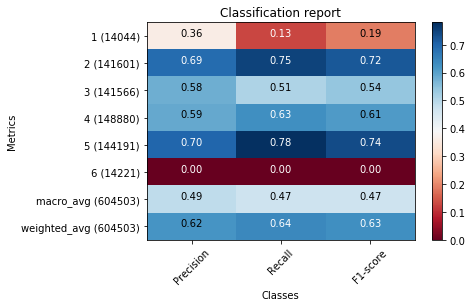

In [142]:
# Compilare la funzione al termine del file prima
plot_classification_report(rep)

In [143]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [144]:
print(cf_matrix)

[[  1854  11617    493    105      0      0]
 [  2351 106661  30612   1822    131      0]
 [   821  34567  71706  32633   1887      1]
 [   145   1872  21721  93988  31193      5]
 [     7     27    439  31063 112431      0]
 [     0      0     52    206  14062      0]]


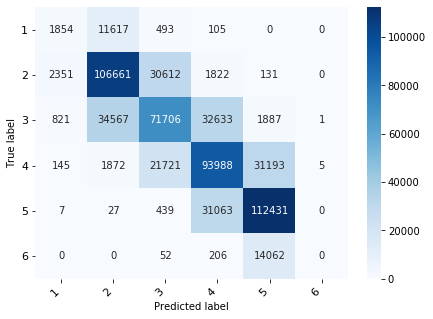

In [145]:
print_confusion_matrix(cf_matrix,class_names,figsize = (7,5), fontsize=11)

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    #plt.tight_layout()

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    #return fig